## 雙均線趨勢策略

In [896]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib
import quantstats
plt.style.use('ggplot')

In [897]:
df = pd.read_csv('台指近月期貨指數.csv')
df = df.rename(columns={'日期':"datetime"})
df.index = pd.to_datetime(df['datetime'])
df.sort_index(inplace=True)
df = df.drop(columns=['datetime', '期貨名稱', '簡稱', '報酬率', '未平倉合約數', '基差', '未沖銷契約數(合計)'])
df.columns=['Open', 'High', 'Low', 'Close', 'Volume']

In [898]:
# trainData = df[(df.index >= '2010-01-01') & (df.index <= '2019-12-31')].copy()  # 樣本內
# trainData = df[(df.index >= '2020-01-01') & (df.index <= '2023-06-30')].copy()  # 樣本外
trainData = df[(df.index >= '2010-01-01') & (df.index <= '2023-06-30')].copy()  # 全樣本

In [899]:
settlementDate = pd.read_csv('settlementDate.csv')
settlementDate.columns = ['settlementDate', 'futures', 'settlementPrice']
bool = []
for i in settlementDate['futures']:
    if 'W' in i:
        bool.append(False)
    else:
        bool.append(True)
settlementDate = [i.replace('/','-') for i in list(settlementDate[bool]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [900]:
fund = 1000000
feePaid = 600
fast = 20
slow = 60

trainData['fastMA'] = trainData['Close'].rolling(window=fast, center=False).mean()
trainData['fastEMA'] = talib.EMA(trainData['Close'], timeperiod=fast)

trainData['slowMA'] = trainData['Close'].rolling(window=slow, center=False).mean()
trainData['slowEMA'] = talib.EMA(trainData['Close'], timeperiod=slow)

# 趨勢強度
trainData['strength'] = (trainData['fastEMA']-trainData['slowEMA'])/trainData['slowEMA']*100

trainData.tail(3)

,Open,High,Low,Close,Volume,fastMA,fastEMA,slowMA,slowEMA,strength
datetime,,,,,,,,,,
2023-06-28,16795.0,16810.0,16712.0,16776.0,75639,16910.55,16841.760852,16174.383333,16301.425543,3.314651
2023-06-29,16851.0,16965.0,16733.0,16756.0,111710,16919.55,16833.593152,16191.316667,16316.329624,3.170220
2023-06-30,16718.0,16826.0,16671.0,16788.0,76943,16934.50,16829.250947,16207.433333,16331.794226,3.045940


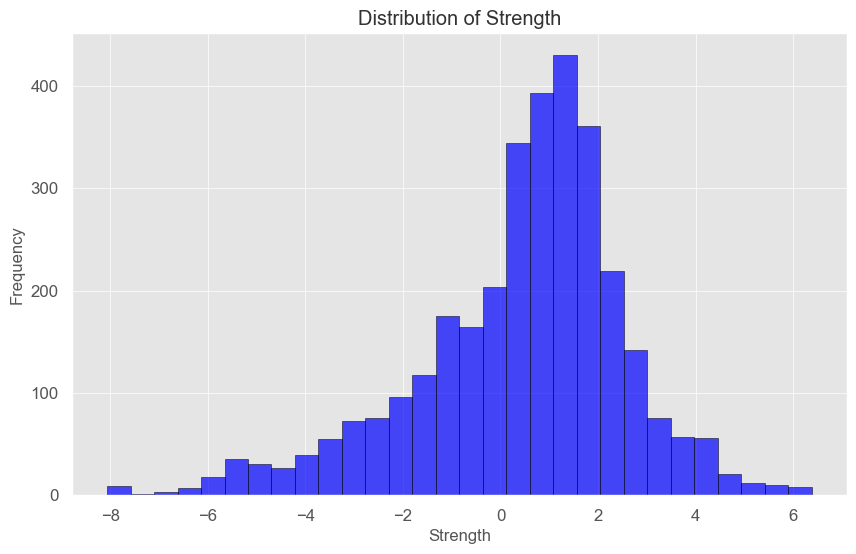

In [901]:
plt.figure(figsize=(10, 6))
plt.hist(trainData['strength'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Strength')
plt.xlabel('Strength')
plt.ylabel('Frequency')
plt.grid(True)

In [902]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]  # 提取日期部分

### 做多

<Axes: xlabel='datetime'>

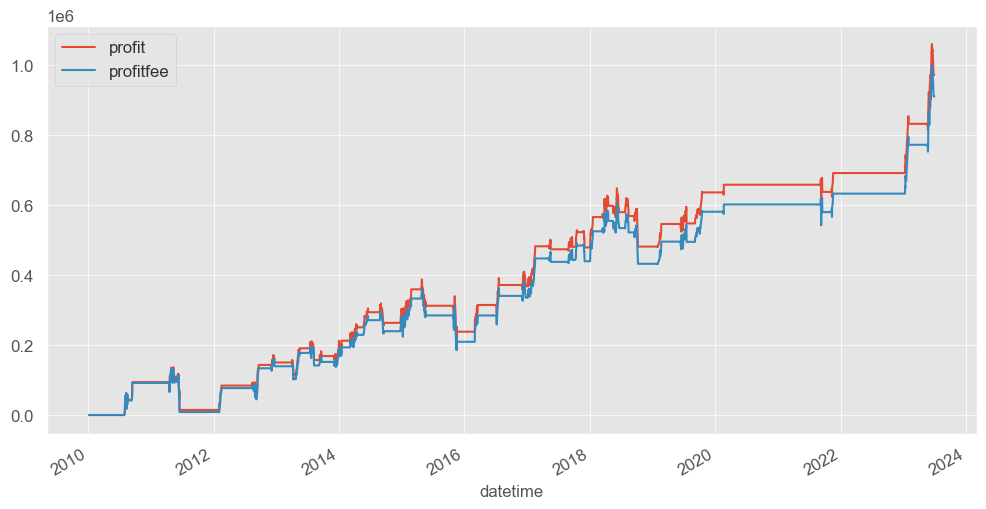

In [903]:
BS = None  # 交易狀態
buy = []   # 買入時間點
sell = []  # 賣出時間點
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

# 開始交易流程
for i in range(len(df_arr)):

    # 回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ### 進場邏輯
    entryLong = (
        # 破線
        (df_arr[i,3] > df_arr[i,5]) and (df_arr[i,3] > df_arr[i,6]) and
        # 均線拐頭 
        (df_arr[i,5] > df_arr[i-1,5]) and  
        (df_arr[i,6] > df_arr[i-1,6]) and
        (df_arr[i,7] > df_arr[i-1,7]) and
        (df_arr[i,8] > df_arr[i-1,8]) and
        # 趨勢強度 (均線密集時進場)
        (-0.5 < df_arr[i,9] < 1)
    )
    entryCondition = date_arr[i] not in settlementDate  # 結算日不進場

    ### 出場邏輯
    exitShort = (
        # 破線
        (df_arr[i,3] < df_arr[i,5]) and (df_arr[i,3] < df_arr[i,6]) and
        # 均線拐頭
        (df_arr[i,5] < df_arr[i-1,5]) and 
        (df_arr[i,6] < df_arr[i-1,6]) and
        (df_arr[i,7] < df_arr[i-1,7]) and
        (df_arr[i,8] < df_arr[i-1,8])  
    )
    exitCondition = date_arr[i] in settlementDate # 結算日直接平倉   

    # 做多的狀態
    # if BS == 'B':
    #     # 停利停損條件
    #     stopLoss = df_arr[i,3] <= (df_arr[t,0] - df_arr[t,10] * 1.5) 
    #     stopProfit = df_arr[i,3] >= (df_arr[t,0] + df_arr[t,10] * 1.5) 

    # 還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        # 確認進場&相關設定
        if entryLong and entryCondition:
            # 更改狀態至作多
            BS = 'B'
            # 紀錄進場時間
            t = i+1
            buy.append(t)
            # print('Buy Price: {}, time: {}'.format(df_arr[t,0], time_arr[t]))
    
    # 進場才開始計算未實現損益 
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
         # 出場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition:  # -2是因為出場條件達成後隔天才出場，所以其實是最後一天出場的意思
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])  # 部位從買到賣賺的價差
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            
            # 紀錄出場時間
            sell.append(i+1)

            # 重置交易狀態
            BS = None
            # print('Sell Price: {}, time: {}'.format(df_arr[i+1,0], time_arr[i+1]))
            # print('Trade completed')
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
         
        # 出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6))

(np.float64(14705.0), np.float64(19538.0))

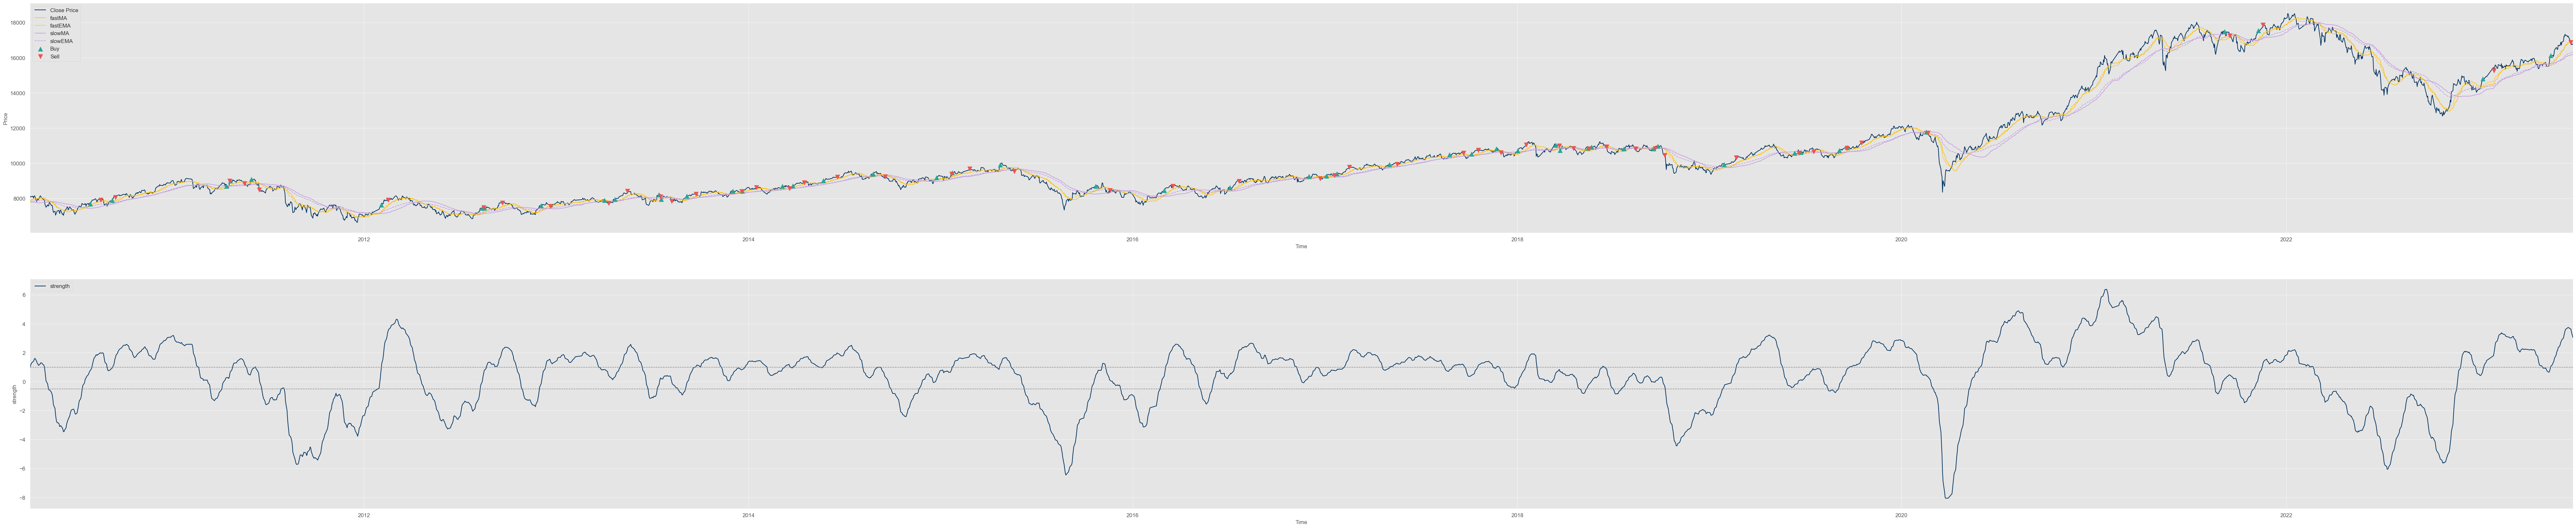

In [904]:
plt.figure(figsize=(100, 20))

plt.subplot(2,1,1)
plt.plot(trainData.index, trainData['Close'], label='Close Price', color='#013360', zorder=1, linewidth=1.5)
plt.plot(trainData.index, trainData['fastMA'], label='fastMA', color='#ffc000', linestyle='-', linewidth=1.2, zorder=1)
plt.plot(trainData.index, trainData['fastEMA'], label='fastEMA', color='#ffc000', linestyle='--', linewidth=1.2, zorder=1)
plt.plot(trainData.index, trainData['slowMA'], label='slowMA', color='#c198e0', linestyle='-', linewidth=1.2, zorder=1)
plt.plot(trainData.index, trainData['slowEMA'], label='slowEMA', color='#c198e0', linestyle='--', linewidth=1.2, zorder=1)
plt.scatter(time_arr[buy], df_arr[buy,3], marker='^', color='#26a69a', label='Buy', s=100, zorder=2)
plt.scatter(time_arr[sell], df_arr[sell,3], marker='v', color='#ef5350', label='Sell', s=100, zorder=2)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
# 設置只顯示所有 MA 和 EMA 都有數據的區間 (從60MA有數據的時間點開始)
start_date = trainData['slowMA'].first_valid_index()
plt.xlim([start_date, trainData.index[-1]])

plt.subplot(2,1,2)
plt.plot(trainData.index, trainData['strength'], label='strength', color='#013360', linewidth=1.5)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=-0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Time')
plt.ylabel('strength')
plt.legend(loc='upper left')
plt.grid(True)
start_date = trainData['slowMA'].first_valid_index()
plt.xlim([start_date, trainData.index[-1]])

In [905]:
## 基本指標
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell)  
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,91.1%
2,年化報酬,5.2%
3,年化波動度,7.51%
4,MDD,12.93%
5,年化夏普,0.69
6,風報比,7.05
7,交易次數,102
8,獲利因子,2.64
9,勝率,66.67%


Text(0.5, 1.0, 'Strategy VS. Buy&hold')

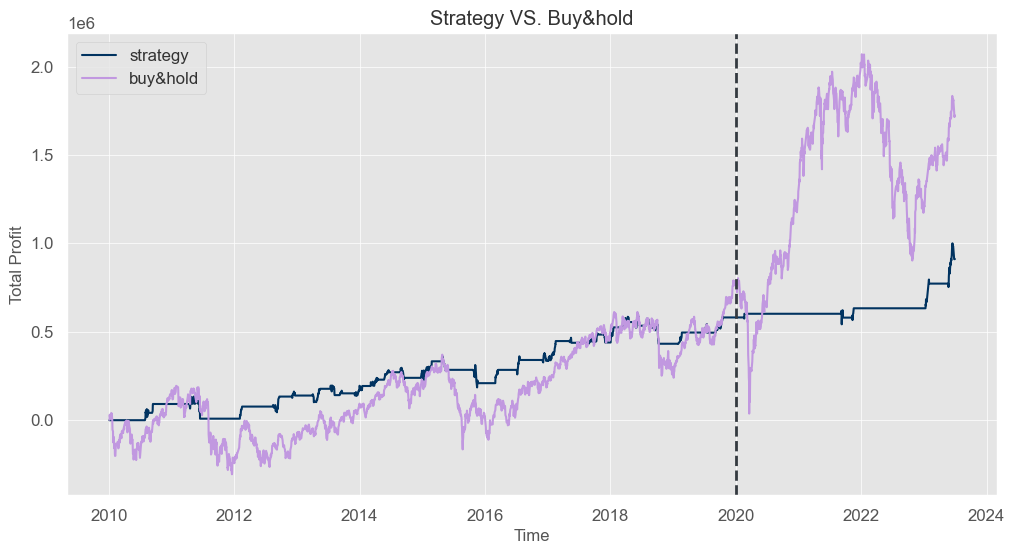

In [906]:
## 比較單獨持有與執行策略的損益
trainData['ret']=trainData['Close'].diff()*200
trainData['cum_ret']=trainData['ret'].cumsum()
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'], label="strategy", c="#013360")
plt.plot(trainData['cum_ret'], label='buy&hold', c="#c198e0")
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Strategy VS. Buy&hold')

Text(0.5, 1.0, 'Profit & Drawdown')

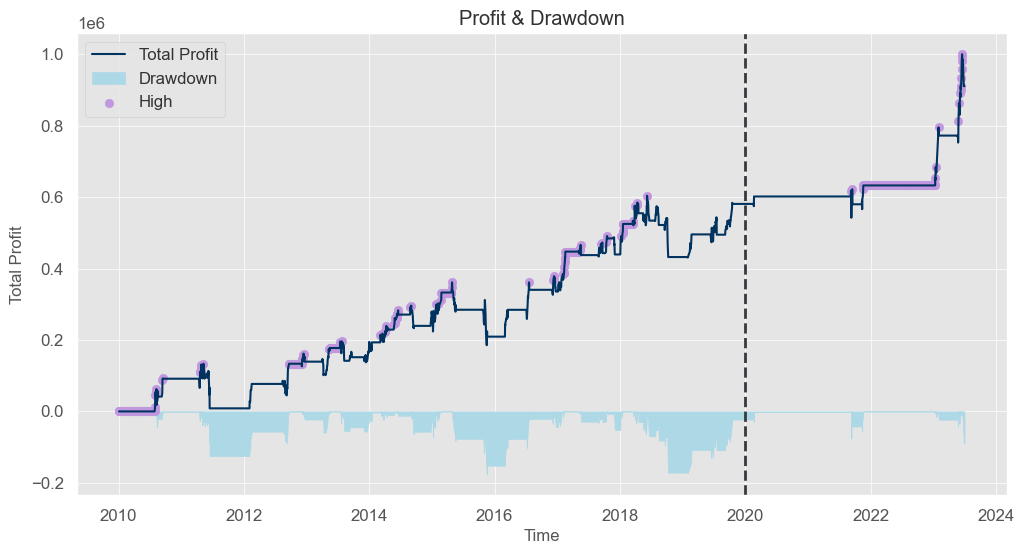

In [907]:
## Profit & Drawdown 
MDD_series = equity['profitfee'].cummax() - equity['profitfee']
high_index = equity['profitfee'][equity['profitfee'].cummax() == equity['profitfee']].index
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'],label="Total Profit" ,c="#013360")
plt.fill_between(MDD_series.index, -MDD_series, 0, label='Drawdown', color='lightblue')
plt.scatter(high_index, equity['profitfee'].loc[high_index], c='#c198e0', label='High')
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Profit & Drawdown')

Text(0.5, 1.0, 'Return by year')

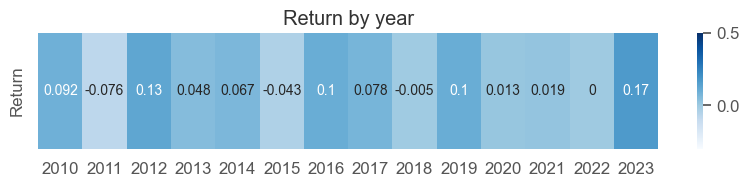

In [908]:
## 時間損益(年)
equity.index = pd.to_datetime(equity.index)  # 確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
year_ret = []
# print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)
df1 = pd.DataFrame({'Return':year_ret}, index = years)

# heatmap
plt.figure(figsize=(10,1.5))
sns.heatmap(df1.transpose(), annot=True, cmap='Blues', vmin=-0.3, vmax=0.5)
plt.title('Return by year')

Text(0.5, 1.0, 'MDD by year')

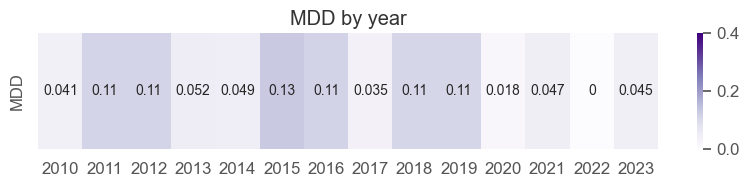

In [909]:
## 時間MDD(年)
equity.index = pd.to_datetime(equity.index)  # 確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
year_MDD = []
# print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_MDD.append(abs(equity[equity.index.year == i]['drawdown_percent'].min()))
df1 = pd.DataFrame({'MDD':year_MDD}, index = years)

# heatmap
plt.figure(figsize=(10,1.5))
sns.heatmap(df1.transpose(), annot=True, cmap='Purples', vmin=0, vmax=0.4)
plt.title('MDD by year')

### 參數最佳化

In [910]:
# # 要確認為樣本內資料
# optimizationList = []
# fund = 1000000
# feePaid = 600
# fast = 20
# slow = 60
# up = 1
# down = -0.5

# for fast in range(10, 60, 10):
#     for slow in range(20, 100, 10):
#                 for up in np.arange(0, 3, 0.5):
#                     for down in np.arange(0, 4, 0.5):

#                         up = np.round(up, 1)
#                         down = np.round(down, 1)
#                         print('----------')
#                         print(f'fastperiod: {fast}')
#                         print(f'slowperiod: {slow}')
#                         print(f'signalperiod: {up}')
#                         print(f'timeperiod: {down}')

#                         # 技術指標
#                         trainData['fastMA'] = trainData['Close'].rolling(window=fast, center=False).mean()
#                         trainData['fastEMA'] = talib.EMA(trainData['Close'], timeperiod=fast)

#                         trainData['slowMA'] = trainData['Close'].rolling(window=slow, center=False).mean()
#                         trainData['slowEMA'] = talib.EMA(trainData['Close'], timeperiod=slow)

#                         trainData['strenth'] = (trainData['fastEMA']-trainData['slowEMA'])/trainData['slowEMA']*100

#                         df_arr = np.array(trainData)
#                         time_arr = np.array(trainData.index)
#                         date_arr = [pd.to_datetime(i).date() for i in time_arr]  # 提取日期部分

#                         ## 做多
#                         # 建立存放資料的單位
#                         BS = None  # 交易狀態
#                         buy = []   # 買入時間點
#                         sell = []  # 賣出時間點
#                         profit_list = [0]
#                         profit_fee_list = [0]
#                         profit_fee_list_realized = []
#                         rets = []

#                         # 開始交易流程
#                         for i in range(len(df_arr)):

#                             # 回測期間最後一天就跳出這個迴圈
#                             if i == len(df_arr)-1:
#                                 break

#                             ### 進場邏輯
#                             entryLong = (
#                                 # 破線
#                                 (df_arr[i,3] > df_arr[i,5]) and (df_arr[i,3] > df_arr[i,6]) and
#                                 # 均線拐頭 
#                                 (df_arr[i,5] > df_arr[i-1,5]) and  
#                                 (df_arr[i,6] > df_arr[i-1,6]) and
#                                 (df_arr[i,7] > df_arr[i-1,7]) and
#                                 (df_arr[i,8] > df_arr[i-1,8]) and
#                                 # 均線交叉 (短期成本 > 中期成本) 
#                                 # (df_arr[i,5] > df_arr[i,7]) and (df_arr[i,5] > df_arr[i,8]) and
#                                 # (df_arr[i,6] > df_arr[i,7]) and (df_arr[i,6] > df_arr[i,8]) 
#                                 # 趨勢強度變化小時買入
#                                 (-down < df_arr[i,9] < up)
#                             )
#                             entryCondition = date_arr[i] not in settlementDate  # 結算日不進場

#                             ### 出場邏輯
#                             exitShort = (
#                                 # 破線
#                                 (df_arr[i,3] < df_arr[i,5]) and (df_arr[i,3] < df_arr[i,6]) and
#                                 # 均線拐頭
#                                 (df_arr[i,5] < df_arr[i-1,5]) and 
#                                 (df_arr[i,6] < df_arr[i-1,6]) and
#                                 (df_arr[i,7] < df_arr[i-1,7]) and
#                                 (df_arr[i,8] < df_arr[i-1,8]) 
#                                 # 均線交叉 (短期成本 < 中期成本) 
#                                 # (df_arr[i,5] < df_arr[i,7]) and (df_arr[i,5] < df_arr[i,8]) and
#                                 # (df_arr[i,6] < df_arr[i,7]) and (df_arr[i,6] < df_arr[i,8]) 
#                             )
#                             exitCondition = date_arr[i] in settlementDate # 結算日直接平倉   

#                             # 做多的狀態
#                             # if BS == 'B':
#                             #     # 停利停損條件
#                             #     stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
#                             #     stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06

#                             # 還沒進場不用計算損益
#                             if BS == None:
#                                 profit_list.append(0)
#                                 profit_fee_list.append(0)

#                                 # 確認進場&相關設定
#                                 if entryLong and entryCondition:
#                                     # 更改狀態至作多
#                                     BS = 'B'
#                                     # 紀錄進場時間
#                                     t = i+1
#                                     buy.append(t)
                            
#                             # 進場才開始計算未實現損益 
#                             elif BS == 'B':
#                                 profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
#                                 profit_list.append(profit)
#                                 # 出場條件達成，計算未實現損益-交易成本
#                                 if exitShort or i == len(df_arr)-2 or exitCondition:  # -2是因為出場條件達成後隔天才出場，所以其實是最後一天出場的意思
#                                     pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])  # 部位從買到賣賺的價差
#                                     profit_fee = profit - feePaid*2
#                                     profit_fee_list.append(profit_fee)
                                    
#                                     # 紀錄出場時間
#                                     sell.append(i+1)

#                                     # 重置交易狀態
#                                     BS = None

#                                     # Realized PnL
#                                     profit_fee_realized = pl_round - feePaid*2
#                                     profit_fee_list_realized.append(profit_fee_realized)
#                                     rets.append(profit_fee_realized/(200*df_arr[t,0]))
                                
#                                 # 出場條件未達成，計算未實現損益
#                                 else:
#                                     profit_fee = profit
#                                     profit_fee_list.append(profit_fee)
                            
#                         equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
#                         equity['equity'] = equity['profitfee'] + fund
#                         equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
#                         equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
#                         ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
#                         mdd = abs(equity['drawdown_percent'].min())
                        
#                         optimizationList.append([fast, slow, up, down, ret, mdd, ret/mdd])

# optResult = pd.DataFrame(optimizationList, columns=['fast', 'slow', 'up', 'down', 'ret', 'mdd', '風報比'])
# optResult.to_csv("optResult1.csv", index=False)
# optResult.sort_values('ret', ascending=False).iloc[:5]  # 印出報酬前5

### 多空都做

<Axes: xlabel='datetime'>

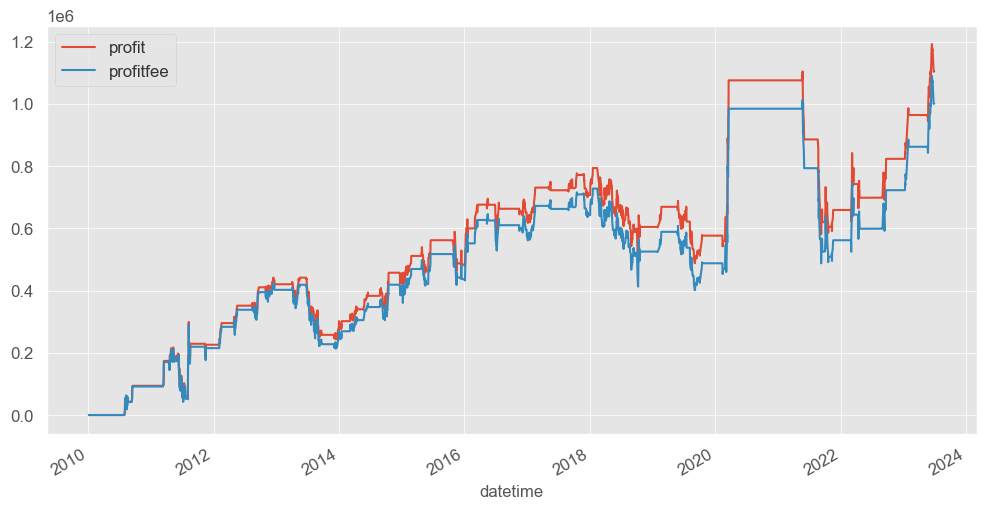

In [911]:
BS = None  # 交易狀態
buy = []   # 買入時間點
sell = []  # 賣出時間點
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

# 開始交易流程
for i in range(len(df_arr)):

    # 回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ### 進場邏輯
    entryLong = (
        # 破線
        (df_arr[i,3] > df_arr[i,5]) and (df_arr[i,3] > df_arr[i,6]) and
        # 均線拐頭 
        (df_arr[i,5] > df_arr[i-1,5]) and  
        (df_arr[i,6] > df_arr[i-1,6]) and
        (df_arr[i,7] > df_arr[i-1,7]) and
        (df_arr[i,8] > df_arr[i-1,8]) and 
        # 趨勢強度變化小 (均線密集)
        (-0.5 < df_arr[i,9] < 1)
    )
    entrySellShort = (
        # 破線
        (df_arr[i,3] < df_arr[i,5]) and (df_arr[i,3] < df_arr[i,6]) and
        # 均線拐頭
        (df_arr[i,5] < df_arr[i-1,5]) and 
        (df_arr[i,6] < df_arr[i-1,6]) and
        (df_arr[i,7] < df_arr[i-1,7]) and
        (df_arr[i,8] < df_arr[i-1,8]) and
        # 趨勢強度變化小 (均線密集)
        (-1 < df_arr[i,9] < 0.5)
    )
    entryCondition = date_arr[i] not in settlementDate  # 結算日不進場

    ### 出場邏輯
    exitShort = (
        # 破線
        (df_arr[i,3] < df_arr[i,5]) and (df_arr[i,3] < df_arr[i,6]) and
        # 均線拐頭
        (df_arr[i,5] < df_arr[i-1,5]) and 
        (df_arr[i,6] < df_arr[i-1,6]) and
        (df_arr[i,7] < df_arr[i-1,7]) and
        (df_arr[i,8] < df_arr[i-1,8]) 
    )
    exitBuyToCover = (
        # 破線
        (df_arr[i,3] > df_arr[i,5]) and (df_arr[i,3] > df_arr[i,6]) and
        # 均線拐頭 
        (df_arr[i,5] > df_arr[i-1,5]) and  
        (df_arr[i,6] > df_arr[i-1,6]) and
        (df_arr[i,7] > df_arr[i-1,7]) and
        (df_arr[i,8] > df_arr[i-1,8]) 
    )
    exitCondition = date_arr[i] in settlementDate # 結算日直接平倉   

    ## 停利停損邏輯
    # if BS == 'B':
    #     stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
    #     stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06
    # elif BS == 'S':
    #     stopLoss = df_arr[i,3] >= df_arr[t,0] * 1.06
    #     stopProfit = df_arr[i,3] <= df_arr[t,0] * 0.94

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)
            # print("Enter Long Position")
            # print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            # print("Enter Short Position")
            # print("Sell Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            # print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            # print("Trade completed")
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            # print("Buycover Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            # print("Trade completed")
            # print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6))

In [912]:
## 基本指標
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell)  
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,100.04%
2,年化報酬,6.23%
3,年化波動度,12.59%
4,MDD,26.1%
5,年化夏普,0.49
6,風報比,3.83
7,交易次數,96
8,獲利因子,1.53
9,勝率,52.33%


Text(0.5, 1.0, 'Strategy VS. Buy&hold')

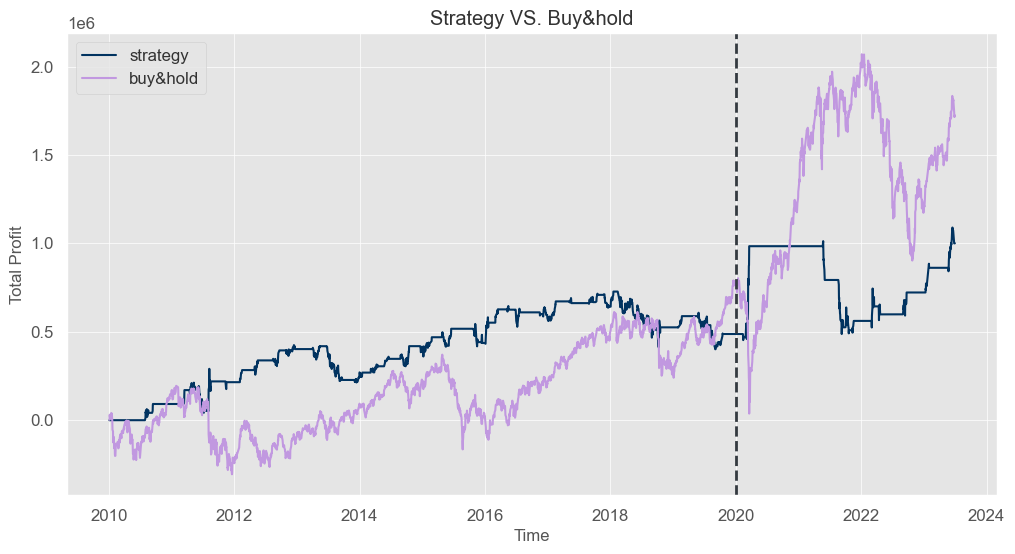

In [913]:
## 比較單獨持有與執行策略的損益
trainData['ret']=trainData['Close'].diff()*200
trainData['cum_ret']=trainData['ret'].cumsum()
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'], label="strategy", c="#013360")
plt.plot(trainData['cum_ret'], label='buy&hold', c="#c198e0")
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Strategy VS. Buy&hold')

### 做多加碼

<Axes: xlabel='datetime'>

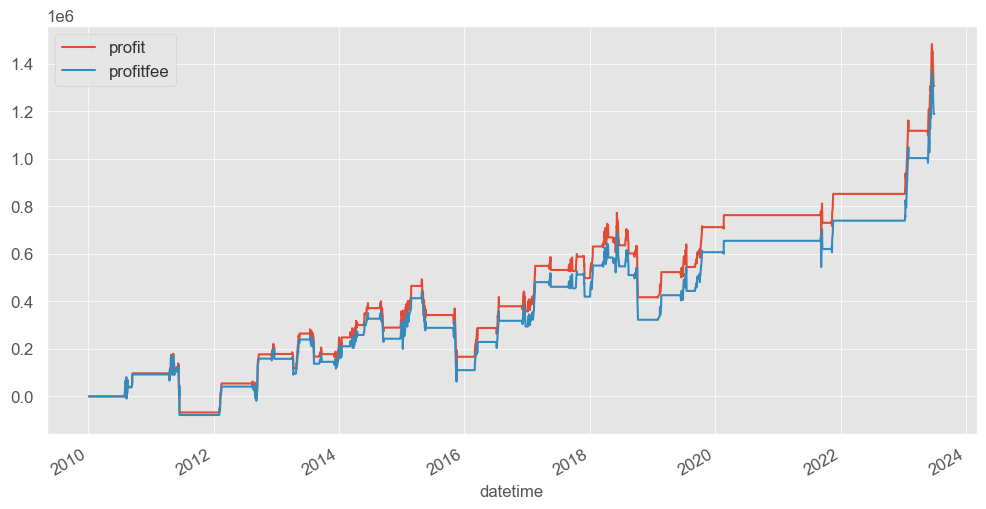

In [914]:
BS = None  # 交易狀態
buy = []   # 買入時間點
sell = []  # 賣出時間點
add = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

Position = 0
buy_price = 0
add_price = 0
cost_list = []

# 開始交易流程
for i in range(len(df_arr)):

    # 回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ### 進場邏輯
    entryLong = (
        # 破線
        (df_arr[i,3] > df_arr[i,5]) and (df_arr[i,3] > df_arr[i,6]) and
        # 均線拐頭 
        (df_arr[i,5] > df_arr[i-1,5]) and  
        (df_arr[i,6] > df_arr[i-1,6]) and
        (df_arr[i,7] > df_arr[i-1,7]) and
        (df_arr[i,8] > df_arr[i-1,8]) and
        # 趨勢強度 (均線密集時進場)
        (-0.5 < df_arr[i,9] < 1)
    )
    entryCondition = date_arr[i] not in settlementDate  # 結算日不進場

    ### 出場邏輯
    exitShort = (
        # 破線
        (df_arr[i,3] < df_arr[i,5]) and (df_arr[i,3] < df_arr[i,6]) and
        # 均線拐頭
        (df_arr[i,5] < df_arr[i-1,5]) and 
        (df_arr[i,6] < df_arr[i-1,6]) and
        (df_arr[i,7] < df_arr[i-1,7]) and
        (df_arr[i,8] < df_arr[i-1,8])  
    )
    exitCondition = date_arr[i] in settlementDate # 結算日直接平倉   

    # 做多的狀態
    if BS == 'B':
    #     # 停利停損條件
    #     stopLoss = df_arr[i,3] <= df_arr[t,0] * 0.94
    #     stopProfit = df_arr[i,3] >= df_arr[t,0] * 1.06
        add_condition = df_arr[i,0] > buy_price

    # 還沒進場不用計算損益
    if (BS == None) and (Position == 0):
        profit_list.append(0)
        profit_fee_list.append(0)

        # 確認進場&相關設定
        if entryLong and entryCondition:
            # 更改狀態至作多
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            cost_list.append(buy_price)
            buy.append(t)
    
    # 進場才開始計算未實現損益 
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)
         # 出場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition:  # -2是因為出場條件達成後隔天才出場，所以其實是最後一天出場的意思
            if Position > 1:
                pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
            else:
                pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            # 紀錄出場時間
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
         
            BS = None
            Position = 0
            buy_price = 0
            add_price = 0

        elif (Position <= 1) & add_condition:
            add_price = df_arr[i+1, 0]
            Position += 1
            cost_list.append(add_price)

            profit_fee = profit
            profit_fee_list.append(profit_fee)
            add.append(i+1)

        # 出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6))

In [915]:
## 基本指標
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1  # 現在相對於過去最高點跌多少?
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() 
profit = equity['profitfee'].iloc[-1]  # 總利潤
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
tradeTimes = len(buy) + len(sell) + len(add)  
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))
# 年化報酬 (單利)
annual_equity = equity['equity'].resample('YE').agg(['first', 'last'])
annual_equity['Return'] = (annual_equity['last'] / annual_equity['first']) - 1
start_date = equity.index.min()
end_date = equity.index.max()
yearnumber = end_date.year - start_date.year + (end_date.month - start_date.month + 1) / 12  
annualret=annual_equity['Return'].sum()/yearnumber
# 日報酬%
daily_return = equity['equity'].pct_change()
# 年化波動度%
annualVolatility = daily_return.std()*(252**0.5)

result = pd.DataFrame({
    "績效指標":['累積報酬', '年化報酬', '年化波動度', 'MDD', '年化夏普', '風報比', '交易次數', '獲利因子', '勝率'],
    "value": [
        f"{round(ret*100, 2)}%",  # 累積報酬
        f"{round(annualret*100, 2)}%",  # 年化報酬
        f"{round(annualVolatility*100, 2)}%",  # 年化波動度
        f"{round(mdd*100, 2)}%",  # MDD
        round(annualret/annualVolatility, 2),  # 年化夏普
        round(ret/mdd, 2),  # 風報比
        tradeTimes,  # 交易次數
        round(profitFactor, 2),  # 獲利因子
        f"{round(winRate*100, 2)}%"  # 勝率
    ]}, index=range(1,10))
result

,績效指標,value
1,累積報酬,118.9%
2,年化報酬,6.88%
3,年化波動度,13.38%
4,MDD,26.31%
5,年化夏普,0.51
6,風報比,4.52
7,交易次數,149
8,獲利因子,1.97
9,勝率,58.82%


Text(0.5, 1.0, 'Strategy VS. Buy&hold')

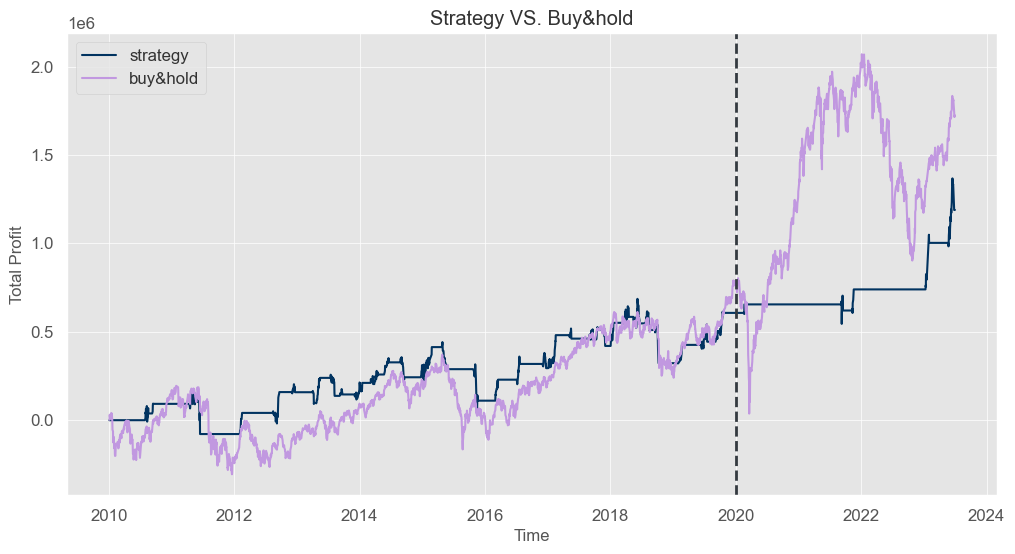

In [916]:
## 比較單獨持有與執行策略的損益
trainData['ret']=trainData['Close'].diff()*200
trainData['cum_ret']=trainData['ret'].cumsum()
plt.figure(figsize=(12,6))
plt.plot(equity['profitfee'], label="strategy", c="#013360")
plt.plot(trainData['cum_ret'], label='buy&hold', c="#c198e0")
plt.axvline(x=pd.Timestamp('2020-01-01'), color='#343a40', linestyle='--', linewidth=2)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title('Strategy VS. Buy&hold')